In [1]:
sc

In [2]:
#df = spark.read.load('yelp_business.csv.csv',format='csv',header=True,inferSchema=True)
rdd = sc.textFile("yelp_business.csv", use_unicode=False)

#header = rdd.filter(lambda l: "business_id" in l)
#header.collect()
#rdd = rdd.subtract(header)

In [3]:
rdd.take(2)

['business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories',
 'FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.3306902,-111.9785992,4.0,22,1,Dentists;General Dentistry;Health & Medical;Oral Surgeons;Cosmetic Dentists;Orthodontists']

In [4]:
import operator

def extractCities(partId,records):
    if partId==0:
        records.next()
    import csv
    reader = csv.reader(records)
    for row in reader:
        yield (row[4]) #Cities #Put comma to explicity define a tuble of size one
        
cities = rdd.mapPartitionsWithIndex(extractCities)
cities = cities.map(lambda city: (city,1)).reduceByKey(lambda x,y: x+y)
cities = cities.toDF()

#Rename
cities = cities.select(cities['_1'].alias('City'),
                       cities['_2'].alias('Number_of_Restaurants'))
cities = cities.sort('Number_of_Restaurants',ascending = False)

total = cities.select("Number_of_Restaurants").agg({"Number_of_Restaurants": "sum"}).collect().pop()['sum(Number_of_Restaurants)']
print(total)
cities = cities.withColumn('Percentage', (cities['Number_of_Restaurants']/total) * 100)
cities.show(20)

174567
+-----------+---------------------+------------------+
|       City|Number_of_Restaurants|        Percentage|
+-----------+---------------------+------------------+
|  Las Vegas|                26775|15.337950471738646|
|    Phoenix|                17213| 9.860397440524268|
|    Toronto|                17206|  9.85638751883231|
|  Charlotte|                 8553| 4.899551461616457|
| Scottsdale|                 8228| 4.713376525918416|
| Pittsburgh|                 6355|3.6404360503417026|
|       Mesa|                 5760| 3.299592706525288|
|  MontrÃ©al|                 5709|3.2703775627695957|
|  Henderson|                 4465|2.5577571935130923|
|      Tempe|                 4263|2.4420423104023095|
|   Chandler|                 3994|2.2879467482399307|
|  Edinburgh|                 3868|  2.21576815778469|
|  Cleveland|                 3322|1.9029942658119807|
|    Madison|                 3213|1.8405540566086374|
|   Glendale|                 3206|1.8365441349166796|
|  

In [5]:
cities.count()

1094

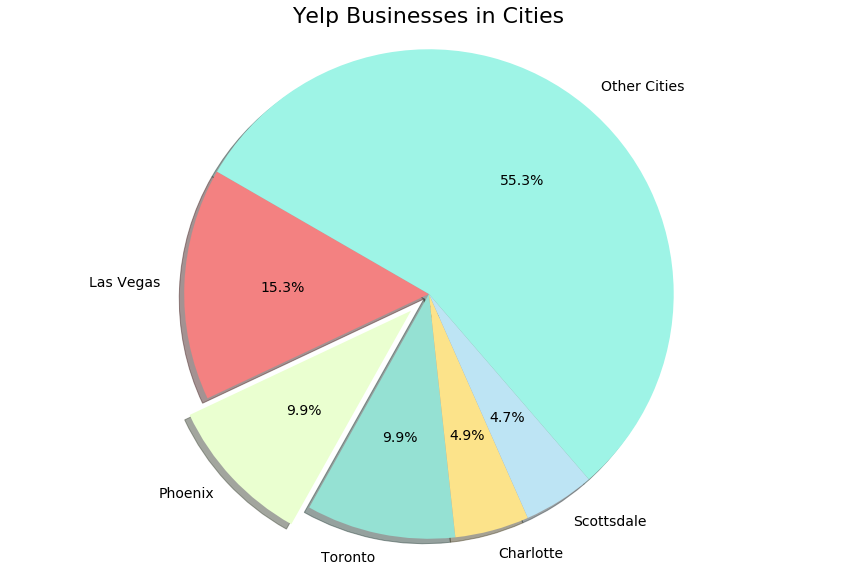

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 53347)
----------------------------------------


Traceback (most recent call last):
  File "C:\Users\migue\Anaconda2\lib\SocketServer.py", line 290, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\migue\Anaconda2\lib\SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\migue\Anaconda2\lib\SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\migue\Anaconda2\lib\SocketServer.py", line 652, in __init__
    self.handle()
  File "C:\spark\python\pyspark\accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "C:\spark\python\pyspark\serializers.py", line 575, in read_int
    length = stream.read(4)
  File "C:\Users\migue\Anaconda2\lib\socket.py", line 384, in read
    data = self._sock.recv(left)
error: [Errno 10054] An existing connection was forcibly closed by the remote host


In [13]:
import matplotlib.pyplot as plt

pop_labels = 'Las Vegas', 'Phoenix','Toronto', 'Charlotte', 'Scottsdale',"Other Cities"
colors = ['#F38181','#EAFFD0','#95E1D3','#FCE38A','#BDE4F4','#9EF4E6']
slide_values = [26775,17213,17206,8553,8228,total-(77975)]
explode = (0, 0.1, 0, 0, 0, 0)  # explode 1st slice
fig = plt.figure(figsize=(12,8))
# Plot
plt.title('Yelp Businesses in Cities', fontsize=22)
patches, texts, autotexts = plt.pie(slide_values, explode=explode, labels=pop_labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=150)
for text,autotext in zip(texts,autotexts):
    text.set_fontsize(14)
    autotext.set_fontsize(14)

plt.axis('equal')

#SAVE IMG
fig1 = plt.gcf()
plt.tight_layout()
plt.show()
plt.draw()
fig1.savefig("yelpBusinessesCities",dp1=100)

In [7]:
#Percentage of bussiness with stars 
def extractStars(partId,records):
    if partId==0:
        records.next()
    import csv
    reader = csv.reader(records)
    for row in reader:
        yield (row[9]) #Cities #Put comma to explicity define a tuble of size one
stars = rdd.mapPartitionsWithIndex(extractStars)
stars = stars.map(lambda star: (star,1)).reduceByKey(lambda x,y: x+y)
stars = stars.toDF()

stars = stars.select(stars['_1'].alias('Stars'),
                       stars['_2'].alias('Number_of_Stars'))
stars = stars.sort('Number_of_Stars',ascending = False)
stars.show()

+-----+---------------+
|Stars|Number_of_Stars|
+-----+---------------+
|  4.0|          33492|
|  3.5|          32038|
|  5.0|          27540|
|  4.5|          24796|
|  3.0|          23142|
|  2.5|          16148|
|  2.0|           9320|
|  1.5|           4303|
|  1.0|           3788|
+-----+---------------+



In [8]:
star_values = stars.select("Stars").rdd.flatMap(lambda x: x).collect()
star_count = stars.select("Number_of_Stars").rdd.flatMap(lambda x: x).collect()
star_count

[33492, 32038, 27540, 24796, 23142, 16148, 9320, 4303, 3788]

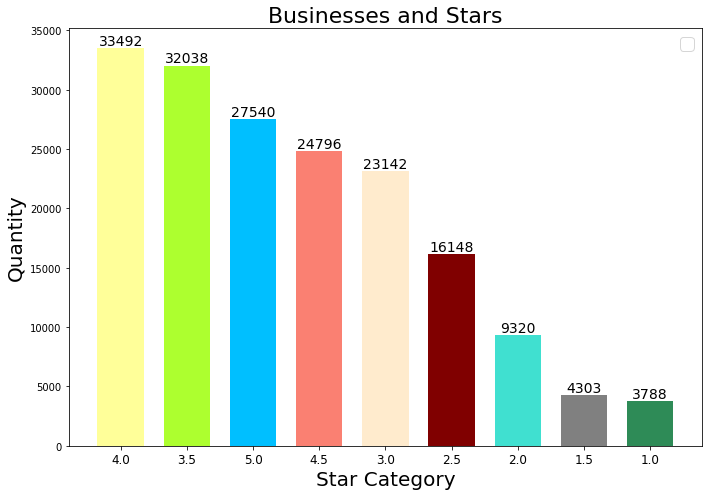

In [12]:
import numpy as np 

width = 0.7 
ind = np.arange(9)  # the x locations for the groups
colors = ['#FFFF99','#ADFF2F','#00BFFF','#FA8072','#FFEBCD','#800000','#40E0D0','#808080','#2E8B57']

fig, ax = plt.subplots(figsize=(10,7))
_bars = ax.bar(ind, star_count , width, color=colors)

#Add some text for labels, title and axes ticks
ax.set_xlabel("Star Category",fontsize=20)
ax.set_ylabel('Quantity',fontsize=20)
ax.set_title('Businesses and Stars',fontsize=22)
ax.set_xticks(ind) #Positioning on the x axis
ax.set_xticklabels(star_values, fontsize = 12)
ax.legend(_bars, [],fontsize=17)

def autolabel(rects,fontsize=14):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),
                ha='center', va='bottom',fontsize=fontsize)
        
autolabel(_bars)        
#SAVE IMG
fig1 = plt.gcf()
plt.tight_layout()
plt.show()
plt.draw()
fig1.savefig("yelpBusinessesStars",dp1=100)

In [10]:
rdd = sc.textFile("yelp_review.csv", use_unicode=False)

In [11]:
from pyspark.sql.types import StringType

def extractReviews(partId,records):
    if partId==0:
        records.next()
    
    import csv
    reader = csv.reader(records)
    
    for row in reader:
        yield row[5] #Cities #Put comma to explicity define a tuble of size one
        
previous = ""
        
def extractReviews2(partId,records):
    if partId==0:
        records.next()
    
    import csv
    reader = csv.reader(records)
    for row in reader:
        yield row
            #yield row[5] #Cities #Put comma to explicity define a tuble of size one

#reviews = rdd.mapPartitionsWithIndex(extractReviews)
reviews = rdd.mapPartitionsWithIndex(extractReviews2)
#reviews = reviews.map(lambda x: x[5])
#reviews = rdd.mapPartitions(extractReviews)
#reviews = spark.read.load('yelp_review.csv',format='csv',header=True,inferSchema=True) #gives TOTAL
#reviews = sqlContext.createDataFrame(reviews)
#reviews = reviews.map(lambda star: (star,1)).reduceByKey(lambda x,y: x+y)
reviews = reviews.map(lambda x: (x, )).toDF()
#reviews = reviews.toDF()
print(type(reviews))
total = reviews.count()
#total = reviews.select("Reviews").agg({"Reviews": "sum"}).collect().pop()['sum(Reviews)']
#print(total)
reviews.show(4)

<class 'pyspark.sql.dataframe.DataFrame'>


KeyboardInterrupt: 

In [ ]:
total

In [ ]:
reviews.take(5)

In [ ]:
review[]